In [1]:
#!pip install -U statsmodels
#!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [34]:
df = pd.read_csv(
    '../datasets/perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,
    parse_dates=True)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_24660\1848457613.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [38]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [40]:
df.shape

(105, 1)

In [67]:
print(df.index.min())
print(df.index.max())

1964-01-01 00:00:00
1972-09-01 00:00:00


In [43]:
df.isna().sum()

Sales    0
dtype: int64

In [44]:
df.index.isna().sum()

np.int64(0)

In [45]:
rango_fechas = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
rango_fechas

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', length=105, freq='MS')

In [48]:
# 2. Usar "difference" para encontrar las diferencias entre este rango y el índice original del *DataFrame*
rango_fechas.difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

<Axes: xlabel='Month', ylabel='Sales'>

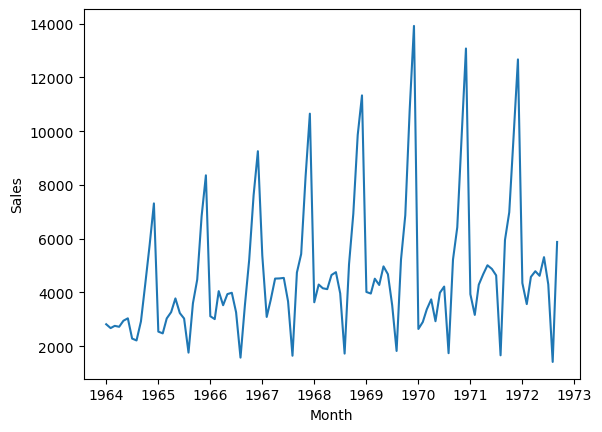

In [49]:
sns.lineplot(df['Sales'])

In [50]:
df.index.freq = 'MS'

In [55]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 12
steps = 10# walk forward steps
Ntest = len(df) - h - steps + 1

In [56]:
Ntest = 12# how do we define this ? , is it because the seasonal cycle is one year
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [57]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

try walk forward validation to detect the better parameters for the model

## walk forward validation

In [68]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 12
steps = 10# walk forward steps
Ntest = len(df) - h - steps + 1

In [81]:
for end_of_train in range(Ntest, len(df) - h + 1):
    print(end_of_train)
    print(end_of_train + h)
    train = df.iloc[:end_of_train]
    test = df.iloc[end_of_train:end_of_train + h]

84
96
85
97
86
98
87
99
88
100
89
101
90
102
91
103
92
104
93
105


In [82]:
df.iloc[100:105]

,Sales
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


In [87]:
def walkforward(
    trend_type,
    seasonal_type,
    damped_trend,
    init_method,
    use_boxcox,
    debug=False):

  # store errors
  errors = []
  seen_last = False
  steps_completed = 0

  for end_of_train in range(Ntest, len(df) - h + 1):
    # We don't have to manually "add" the data to our dataset
    # Just index it at the right points - this is a "view" not a "copy"
    # So it doesn't take up any extra space or computation
    train = df.iloc[:end_of_train]
    test = df.iloc[end_of_train:end_of_train + h]

    if test.index[-1] == df.index[-1]:# this is to ensure we have reacht to the end of the data
      seen_last = True
    
    steps_completed += 1

    hw = ExponentialSmoothing(
        train['Sales'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=12,
        use_boxcox=use_boxcox)
    res_hw = hw.fit()

    # compute error for the forecast horizon
    fcast = res_hw.forecast(h)
    print(train['Sales'])
    print(test['Sales'])
    print(fcast)

    error = mean_squared_error(test['Sales'], fcast)
    errors.append(error)
  
  if debug:
    print("seen_last:", seen_last)
    print("steps completed:", steps_completed)

  return np.mean(errors)

In [88]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list = [ 'estimated','heuristic', 'legacy-heuristic']#'estimated' eliminamos esta opcion porque nos salia que no se podia estimar con menos de dos seasonal cycles
use_boxcox_list = [True, False, 0]# we should review documentation ti have the cero values corresponding to the log transform

In [89]:
# Iterate through all possible options (i.e. grid search)
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list,
)
for x in itertools.product(*tuple_of_option_lists):
  print(x)

('add', 'add', True, 'estimated', True)
('add', 'add', True, 'estimated', False)
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'estimated', True)
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)
('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add

In [90]:
('mul', 'add', True, 'estimated', True)


('mul', 'add', True, 'estimated', True)

In [91]:
walkforward('mul', 'add', True, 'estimated', True, debug=True)

Month
1964-01-01     2815
1964-02-01     2672
1964-03-01     2755
1964-04-01     2721
1964-05-01     2946
              ...  
1970-08-01     1738
1970-09-01     5221
1970-10-01     6424
1970-11-01     9842
1970-12-01    13076
Freq: MS, Name: Sales, Length: 84, dtype: int64
Month
1971-01-01     3934
1971-02-01     3162
1971-03-01     4286
1971-04-01     4676
1971-05-01     5010
1971-06-01     4874
1971-07-01     4633
1971-08-01     1659
1971-09-01     5951
1971-10-01     6981
1971-11-01     9851
1971-12-01    12670
Freq: MS, Name: Sales, dtype: int64
1971-01-01    2.406817e+06
1971-02-01    3.635402e+06
1971-03-01    7.602547e+07
1971-04-01    1.453842e+10
1971-05-01             NaN
1971-06-01             NaN
1971-07-01             NaN
1971-08-01    5.593656e+06
1971-09-01             NaN
1971-10-01             NaN
1971-11-01             NaN
1971-12-01             NaN
Freq: MS, dtype: float64


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


ValueError: Input contains NaN.

In [64]:
# Iterate through all possible options (i.e. grid search)
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list,
)
best_score = float('inf')
best_options = None
for x in itertools.product(*tuple_of_option_lists):
  print(x)
  score = walkforward(*x)

  if score < best_score:
    print("Best score so far:", score)
    best_score = score
    best_options = x

('add', 'add', True, 'estimated', True)
Best score so far: 372691.1835361583
('add', 'add', True, 'estimated', False)


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Best score so far: 312828.21964688145
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
Best score so far: 306313.36919931415
('add', 'add', True, 'heuristic', False)


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
Best score so far: 280492.12117684225
('add', 'add', False, 'estimated', True)
Best score so far: 206030.5014379193
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
Best score so far: 199800.5577984999
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib

('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib

('add', 'mul', True, 'heuristic', 0)
('add', 'mul', True, 'legacy-heuristic', True)
('add', 'mul', True, 'legacy-heuristic', False)


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib

('add', 'mul', True, 'legacy-heuristic', 0)
('add', 'mul', False, 'estimated', True)
('add', 'mul', False, 'estimated', False)
('add', 'mul', False, 'estimated', 0)
('add', 'mul', False, 'heuristic', True)
('add', 'mul', False, 'heuristic', False)
('add', 'mul', False, 'heuristic', 0)
('add', 'mul', False, 'legacy-heuristic', True)
('add', 'mul', False, 'legacy-heuristic', False)
('add', 'mul', False, 'legacy-heuristic', 0)
('mul', 'add', True, 'estimated', True)


c:\Users\ASUS TUF\.conda\envs\ml-zoomcamp\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


ValueError: Input contains NaN.

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [92]:
Ntest = 12# how do we define this ? , is it because the seasonal cycle is one year
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
hw = ExponentialSmoothing(
    train['Sales'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [95]:
df.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [96]:
df.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest)

In [97]:
df.head()

,Sales,HoltWintersTrain,HoltWintersTest
Month,,,
1964-01-01,2815,2846.845000,NaN
1964-02-01,2672,2732.960190,NaN
1964-03-01,2755,2842.555224,NaN
1964-04-01,2721,2832.823872,NaN
1964-05-01,2946,3079.945220,NaN


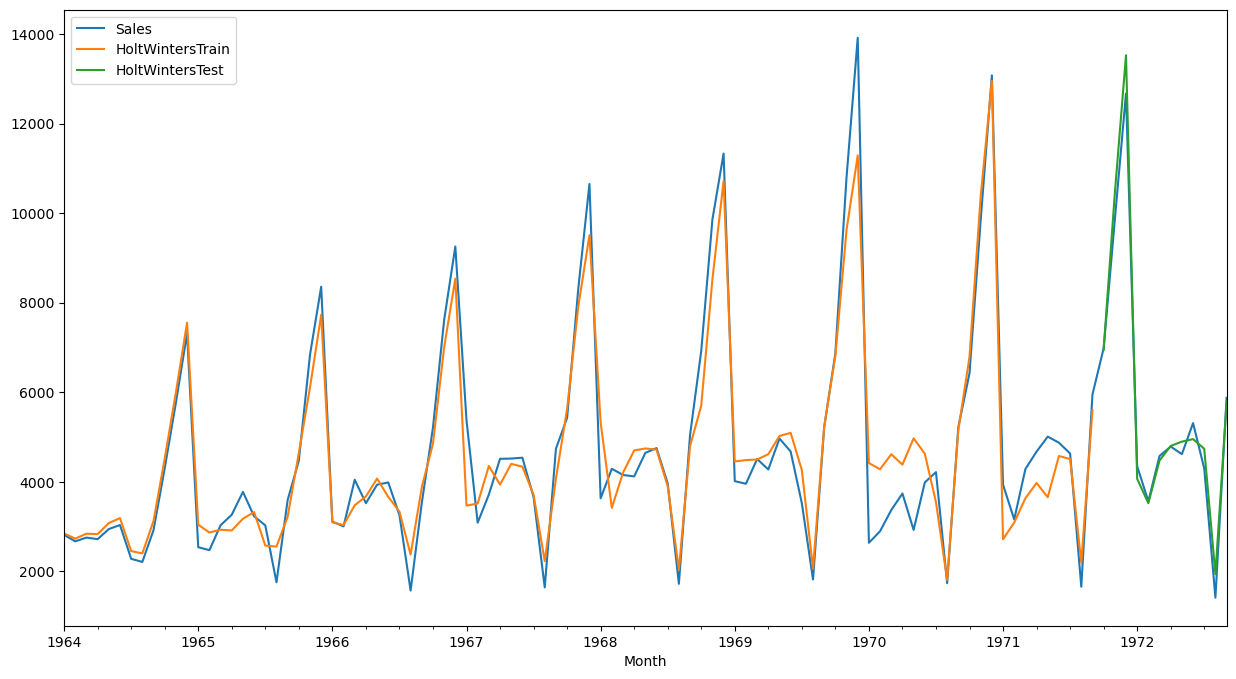

In [98]:
df[['Sales', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 8));

In [100]:
r2_score(train['Sales'], res_hw.fittedvalues)

0.9172437975762145

In [99]:
r2_score(test['Sales'], res_hw.forecast(Ntest))


0.9809922866605445